<a href="https://colab.research.google.com/github/nikhil-xyz/Agentic-AI/blob/main/Agentic_Langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install langchain_community

In [81]:
!pip install arxiv

In [82]:
!pip install wikipedia

In [83]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [84]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [85]:
import os
from dotenv import load_dotenv

In [86]:
from google.colab import userdata
userdata.get('TAVILY_API_KEY')
from google.colab import userdata
userdata.get('GROQ_API_KEY')

'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'

In [87]:
tavily = TavilySearchResults(tavily_api_key=userdata.get('TAVILY_API_KEY'), name = 'tavily_search')

In [88]:
arxiv_api = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=300)
wikipedia_api = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=300)

arxiv = ArxivQueryRun(api_wrapper=arxiv_api)
wikipedia = WikipediaQueryRun(api_wrapper=wikipedia_api)

In [89]:
!pip install langchain_groq

In [90]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key=userdata.get('GROQ_API_KEY'), model='qwen-qwq-32b')

In [91]:
llm.invoke("who is the current captain of the Indian cricket team?").content

"\n<think>\nOkay, so I need to find out who the current captain of the Indian cricket team is. Let me start by recalling what I know. I remember that in cricket, the captain is the leader of the team both on and off the field. The Indian cricket team has had several famous captains over the years, like Sourav Ganguly, Rahul Dravid, and Mahendra Singh Dhoni. More recently, Virat Kohli was the captain for a long time.\n\nWait, was Virat Kohli still the captain? I think he stepped down a while back. When was that? Maybe around early 2022? Let me check my memory. There was a transition period after Kohli. Then there was a captaincy change. I believe Rohit Sharma took over as the captain after Kohli. But am I mixing up the dates? Let me think.\n\nI recall that in 2022, there were some statements from the BCCI (Board of Control for Cricket in India) about changes in leadership. Yes, Rohit Sharma was appointed as the ODI (One Day International) captain first, and then maybe the Test captain a

In [92]:
tools = [arxiv, wikipedia, tavily]

In [93]:
llm_with_tools = llm.bind_tools([arxiv, wikipedia, tavily])

In [94]:
result = llm_with_tools.invoke("who is the current captain of the Indian cricket team?")

In [95]:
result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3dyh', 'function': {'arguments': '{"query": "current captain of the Indian cricket team"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 331, 'prompt_tokens': 404, 'total_tokens': 735, 'completion_time': 0.827235885, 'prompt_time': 0.075932871, 'queue_time': 5.047169497, 'total_time': 0.903168756}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_3796682456', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-88ef714c-1dcb-4a8d-9b76-c2328bd96c5a-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current captain of the Indian cricket team'}, 'id': 'call_3dyh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 404, 'output_tokens': 331, 'total_tokens': 735})

In [96]:
result.tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'current captain of the Indian cricket team'},
  'id': 'call_3dyh',
  'type': 'tool_call'}]

In [97]:
tavily.invoke(result.tool_calls[0]['args']['query'])[0]['content']

'Rohit Sharma is the current captain of Indian Cricket Team for test, One-Day International (ODI), and Twenty20 International cricket (T20) teams.\n\nIndian Cricket Test Match Captain\n\nRohit Sharma was named full-time captain of India in the red-ball format after Virat Kohli, India’s most successful Test captain, resigned in a surprise move following India’s test series loss to South Africa in January 2022. [...] Captains of the Indian Cricket Team: Complete List of All-Time Leaders\n\nRohit Sharma is the Indian cricket team captain (Men), whereas, Harmanpreet Kaur is the current Women’s Indian cricket team captain for all formats. Read on to learn more about the stats of the Captain of the Indian Cricket Team. Find the list of Indian Captains of one-day cricket teams, test matches, and T20 series, in this article.\n\nCaptain Of Indian Cricket Team: Men [...] Rohit Sharma is the current captain of the Indian men’s cricket team for the Test series, ODI, and T20I. For the women’s crick

In [98]:
!pip install langgraph

In [99]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

In [100]:
class State(TypedDict):
  messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [101]:
class LLMNode:
  def __init__(self, llm):
    self.llm = llm

  def __call__(self, state:State):
    return {'messages' : [self.llm.invoke(state['messages'])]}

tool_llm = LLMNode(llm_with_tools)

In [102]:
from langgraph.graph import START
from langgraph.prebuilt import ToolNode, tools_condition

In [103]:
tool_node = ToolNode(tools)

In [104]:
graph_builder.add_node("llm", tool_llm)
graph_builder.add_node("tools", tool_node)

In [105]:
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", tools_condition)
graph_builder.add_edge("tools", "llm")

In [106]:
agent = graph_builder.compile()

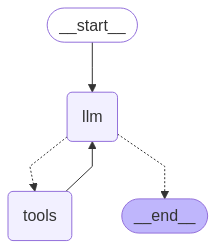

In [107]:
from IPython.display import display, Image
display(Image(agent.get_graph().draw_mermaid_png()))

In [112]:
from langchain_core.messages import HumanMessage

In [116]:
answer = agent.invoke({'messages' : HumanMessage(content = 'who is the current cricket captain of the India?')})

In [122]:
answer['messages'][-1].content

'The current captains of the India cricket team are:\n\n- **Rohit Sharma**:** Captain for Test matches and ODI (One Day International) cricket.\n- **Suryakumar Yadav:** Captain for T20I (Twenty20 International) cricket.\n\nThis split was implemented after Rohit Sharma retired from T20I captaincy in 2023, with Suryakumar taking over the T20I role. As of the latest updates, Rohit continues to lead in red-ball formats (Tests and ODIs), while Suryakumar leads the T20I team.'